# Introduction to ML: Assignment 2

# 2- Develop model

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

X_train = pd.read_csv("train_features.csv")
y_train = pd.read_csv("train_labels.csv")

X_test = pd.read_csv("valid_features.csv")
y_test = pd.read_csv("valid_labels.csv")

def train(X_train, X_test, y_train, y_test, seed=0):
    
    #preporcessing
    from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
    from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer,scale
    #Handle categorical features
    X = pd.get_dummies(X_train, columns = ["key"], drop_first= True)
    Xt = pd.get_dummies(X_test, columns = ["key"], drop_first= True)
    #reorder
    X = pd.concat([X.iloc[:,:8],X.iloc[:,-11:] , X.iloc[:,8:-11]], axis=1)
    Xt = pd.concat([Xt.iloc[:,:8],Xt.iloc[:,-11:] , Xt.iloc[:,8:-11]], axis=1)
    #add feature
    X['tagCount'] = [len(i) for i in X.tags.str.split(',')]
    Xt['tagCount'] = [len(i) for i in Xt.tags.str.split(',')]
    
    #handle text features

    vect = TfidfVectorizer(stop_words='english', ngram_range = (1,1), min_df=10)
    vectT = TfidfVectorizer(stop_words='english', ngram_range = (1,1), min_df=10)

    
    #calculate scores
    matrix = vect.fit_transform(X.tags)
    df1 = pd.DataFrame(matrix.toarray(), columns=vect.get_feature_names())
        #separete matrix for title
    matrixT = vectT.fit_transform(X.title)
    titleNames = [i + "T" for i in vectT.get_feature_names()]
    df2 = pd.DataFrame(matrixT.toarray(), columns=titleNames)
        
    #transform testing
    matrixt = vect.transform(Xt.tags)
    df3 = pd.DataFrame(matrixt.toarray(), columns=vect.get_feature_names())
    matrixtT = vectT.transform(Xt.title)
    df4 = pd.DataFrame(matrixtT.toarray(), columns=titleNames)
        
    X2 = pd.concat([X,df1,df2], axis = 1)
    Xt2 = pd.concat([Xt, df3, df4], axis = 1)
    
    #handle continuos
    
    scaler = MinMaxScaler()
    normal = scaler.fit_transform(X2.iloc[:,3:])
    X4 = X2.copy()
    X4.iloc[:,3:] = normal
    
    normalT = scaler.transform(Xt2.iloc[:,3:])
    Xtest = Xt2.copy()
    Xtest.iloc[:,3:] = normalT
    
    X4, Xtest
    
    #oversampling
    from imblearn.over_sampling import SMOTE
    ros = SMOTE()
    X_resampled, y_resampled = ros.fit_resample(X4.iloc[:,3:], y_train.genre)
    
    #feature selection
    #Get scores for each feature
    #ignore trackID, title and tags fetures
    from sklearn.feature_selection import mutual_info_classif

    res = zip(X_resampled.columns,
                   mutual_info_classif(X_resampled, y_resampled, discrete_features=True)
                   )
    sorted_scores = sorted(res, key= lambda k: k[1], reverse=True)
    
    #filter best 200 features
    X5 = X_resampled[[i for i,e in sorted_scores[:2000]]]
    Xtest = Xtest[[i for i,e in sorted_scores[:2000]]]
    # support vector model train model
    from sklearn.svm import SVC
    
    model = SVC(kernel= 'poly', random_state = seed).fit(X5, y_resampled)
    
    return model, Xtest
    

def predict(model, X_test):
    from sklearn import metrics
    return model.predict(X_test)
    
    
def evaluate(prediction, y_test):
    return metrics.classification_report(y_test, prediction)


In [144]:
model, X_test2 = train(X_train, X_test, y_train, y_test)

prediction = predict(model, X_test2)

result = evaluate(prediction, y_test.genre)

print(result)

                       precision    recall  f1-score   support

 classic pop and rock       0.41      0.60      0.49        55
dance and electronica       0.39      0.27      0.32        45
                 folk       0.54      0.67      0.60        64
       jazz and blues       0.72      0.30      0.42        44
                metal       0.94      0.67      0.78        66
                  pop       0.95      1.00      0.97        74
                 punk       0.66      0.84      0.74        44
      soul and reggae       0.73      0.74      0.74        58

             accuracy                           0.66       450
            macro avg       0.67      0.64      0.63       450
         weighted avg       0.69      0.66      0.66       450



# 1- background Analysis

### Task
You will develop Machine Learning models which predict the music genre based on a diverse set of features,
capturing audio features of the track, as well as song metadata such as its title, key, duration, and textual tags
representing the words in the song lyrics. You will implement and analyze different Machine Learning models
in their performance; and explore the utility of the different types of features for music genre prediction.
We will use a hold-out strategy to evaluate the trained model using a validation, and a test set:
1. The training phase: This will involve training your classifier(s) and parameter tuning where required.
You will use the train features and train lyrics files.
2. The validation phase: This is where you observe the performance of the classifier(s). The validation
data is labelled: you should run the classifier that you built in the training phase on this data to calculate
one or more evaluation metrics to discuss in your report. This phase will help you to find the best model
that can be used for the testing phase.
3. The testing phase: The test data is unlabeled; you should use your preferred model to produce a prediction for each test instance, and submit your predictions to Kaggle website; we will use this output to
confirm the observations of your approach.
N.B: Various Machine Learning techniques have been (or will be) discussed in this subject (Naive Bayes,
Decision Trees, 0-R, etc.); many more exist. You are strongly encouraged to make use of existing Machine
Learning libraries (such as sklearn) in your attempts at this project.

### Code
You must submit one or more programs, written in Python, which implement Machine Learning models, make
predictions, and evaluate as well as a README file that briefly details your implementation. Note that you are
strongly encouraged to use existing Machine learning libraries (such as sklearn) in your attempt at building a
model. Your code must include the following functions:
- train(): where you build your Machine Learning model from the training data.
- predict(): where you use your trained model to predict a class for the validation data.
- evaluate(): where you will output the accuracy of your model based on an evaluation metric.
You may implement other functions as you require.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load dataset

In [3]:
#Load the dataset to a pandas dataFrame
X_train = pd.read_csv("train_features.csv")
y_train = pd.read_csv("train_labels.csv")

X_test = pd.read_csv("valid_features.csv")
y_test = pd.read_csv("valid_labels.csv")


In [4]:
finalTest = pd.read_csv("test_features.csv")

### Explore dataset

In [5]:
X_train.head(2)

,trackID,title,tags,loudness,tempo,time_signature,key,mode,duration,vect_1,...,vect_139,vect_140,vect_141,vect_142,vect_143,vect_144,vect_145,vect_146,vect_147,vect_148
0,8424,The Calamity [Explicit],"the, you, to, a, not, in, of, that, are, we, w...",-2.824,131.969,4,0,1,298.13506,52.050795,...,0.001097,0.001161,0.001225,0.001251,0.001238,0.001202,0.001130,0.001040,0.104525,0.335818
1,7923,Try To Find Me,"i, the, you, to, and, a, me, it, not, in, my, ...",-11.249,136.510,4,4,1,248.03220,38.488583,...,0.000117,0.000134,0.000147,0.000161,0.000157,0.000126,0.000121,0.000134,0.124080,1.553742


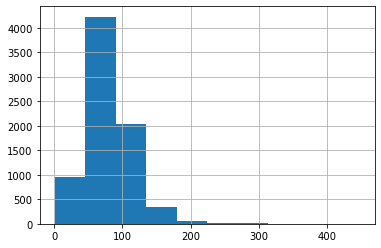

In [6]:
# Distribution of tags length
pd.Series([len(i) for i in X_train.tags.str.split(',')]).hist()

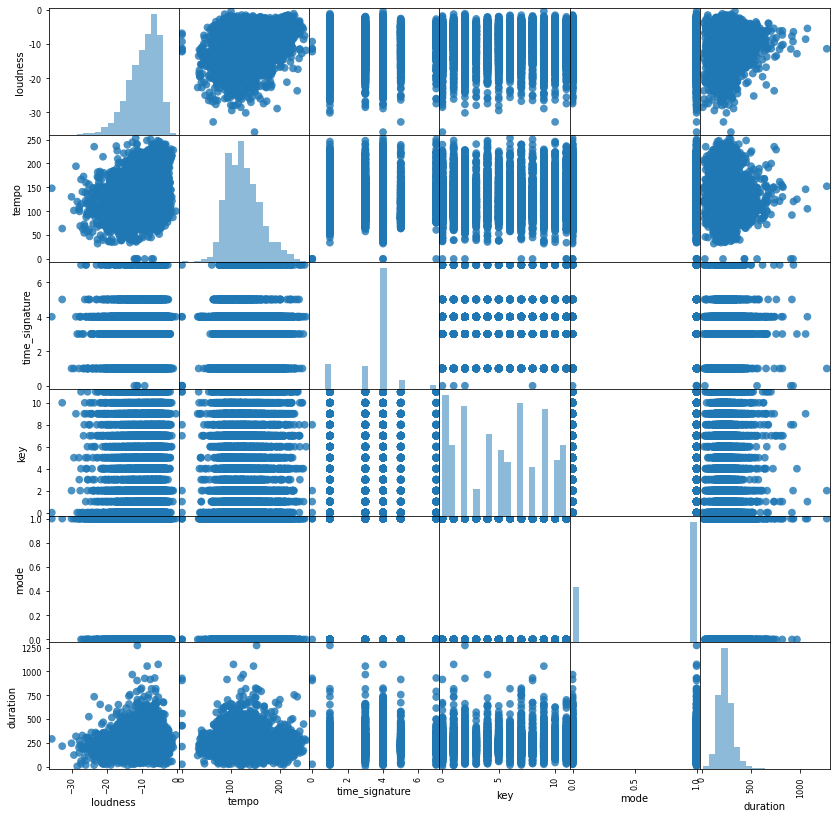

In [7]:
pd.plotting.scatter_matrix(X_train.iloc[:,3:9], figsize=(14, 14), marker='o',hist_kwds={'bins': 20, 'alpha': 0.5}, s=60, alpha=.8);

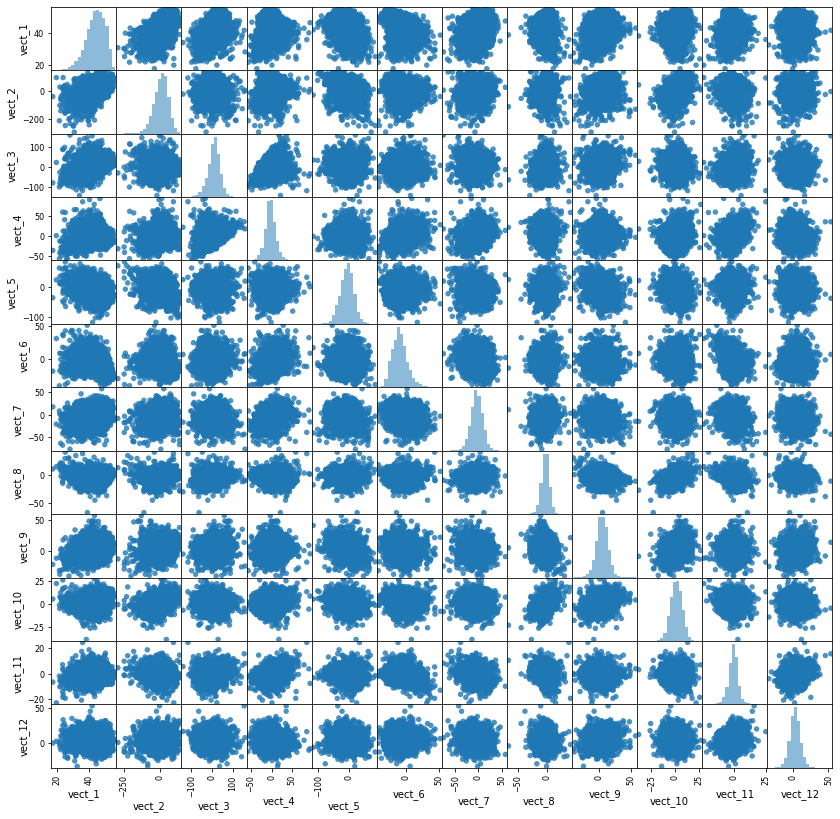

In [8]:
pd.plotting.scatter_matrix(X_train.iloc[:,9:9+12], figsize=(14, 14), marker='o',hist_kwds={'bins': 20, 'alpha': 0.5}, s=30, alpha=.8);

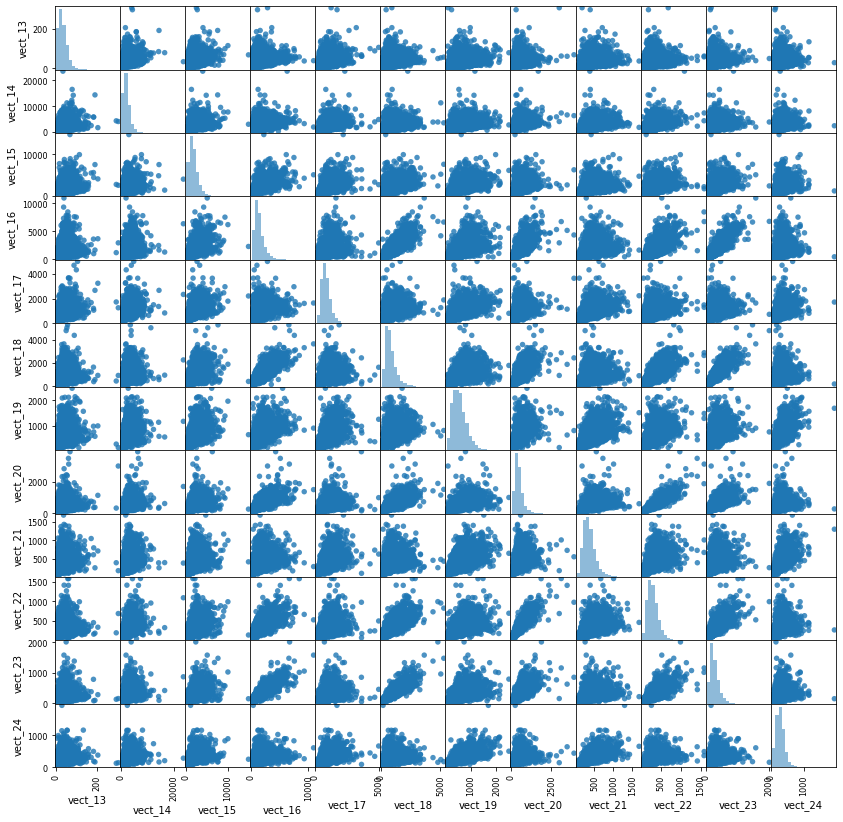

In [9]:
pd.plotting.scatter_matrix(X_train.iloc[:,9+12:9+12+12], figsize=(14, 14), marker='o',hist_kwds={'bins': 20, 'alpha': 0.5}, s=30, alpha=.8);

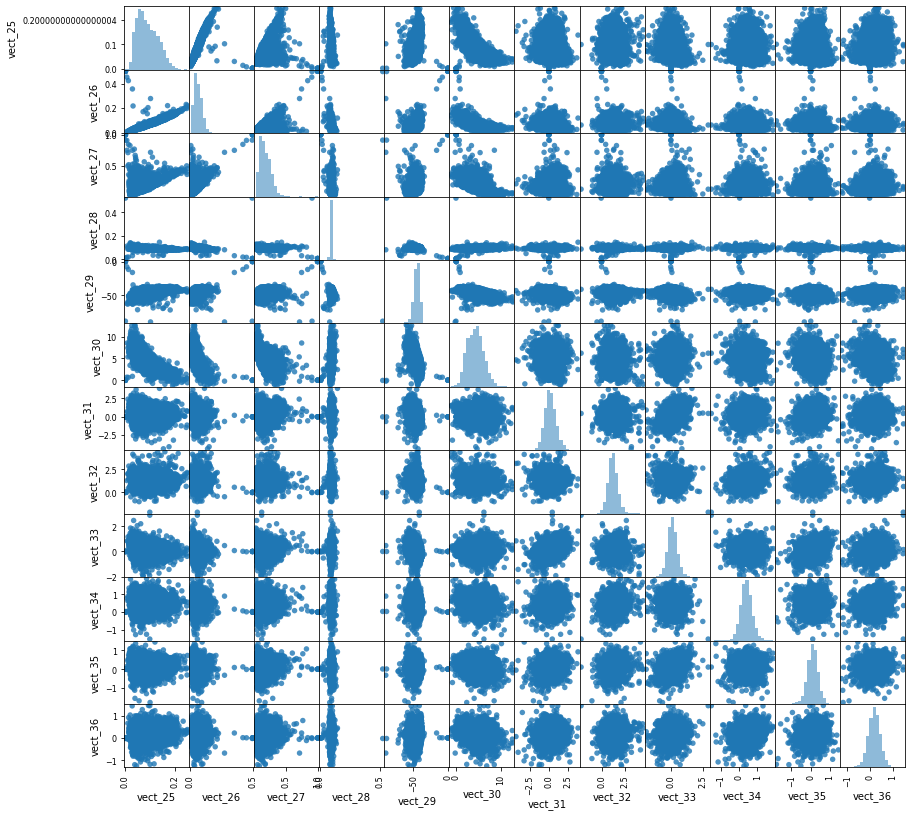

In [10]:
pd.plotting.scatter_matrix(X_train.iloc[:,9+12+12:9+12+12+12], figsize=(14, 14), marker='o',hist_kwds={'bins': 20, 'alpha': 0.5}, s=30, alpha=.8);

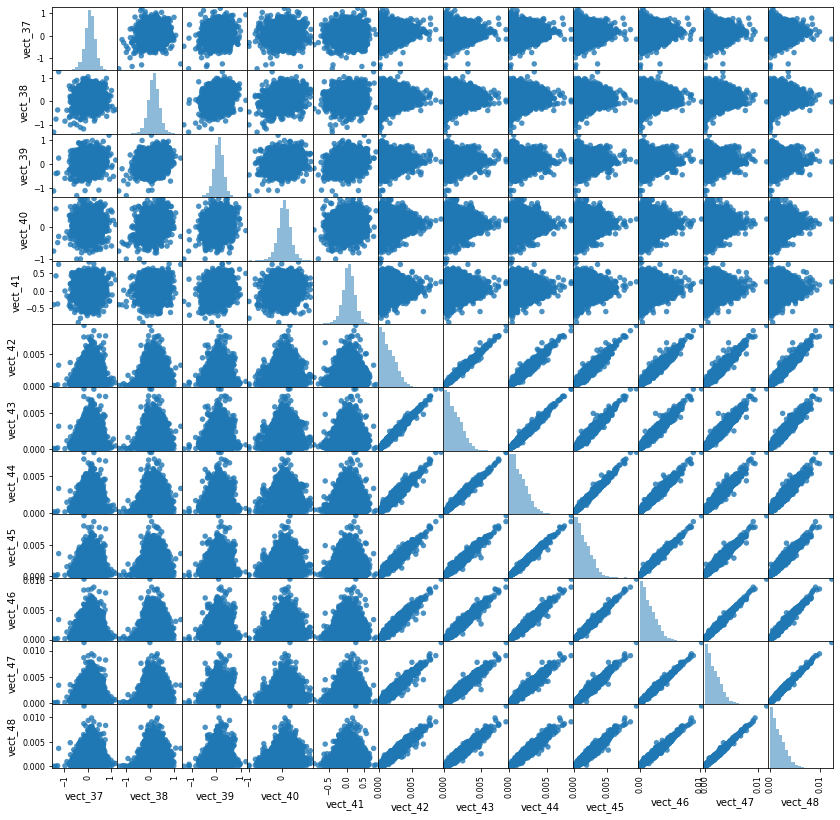

In [11]:
pd.plotting.scatter_matrix(X_train.iloc[:,9+12+12+12:9+12+12+12+12], figsize=(14, 14), marker='o',hist_kwds={'bins': 20, 'alpha': 0.5}, s=30, alpha=.8);

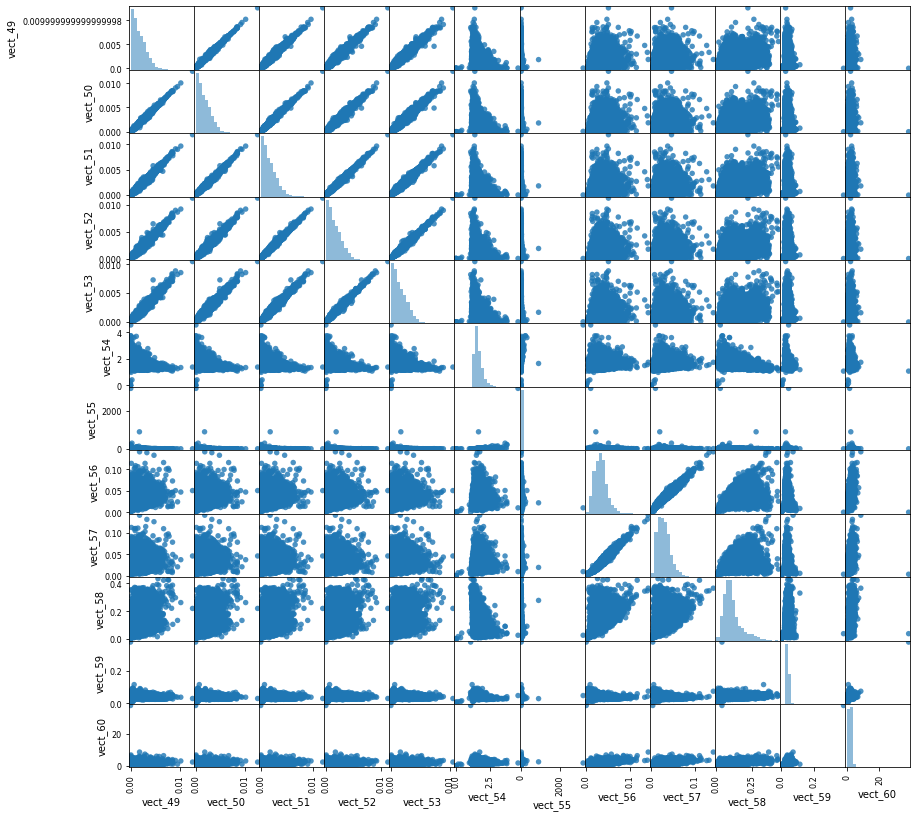

In [12]:
pd.plotting.scatter_matrix(X_train.iloc[:,9+12+12+12+12:9+12+12+12+12+12], figsize=(14, 14), marker='o',hist_kwds={'bins': 20, 'alpha': 0.5}, s=30, alpha=.8);

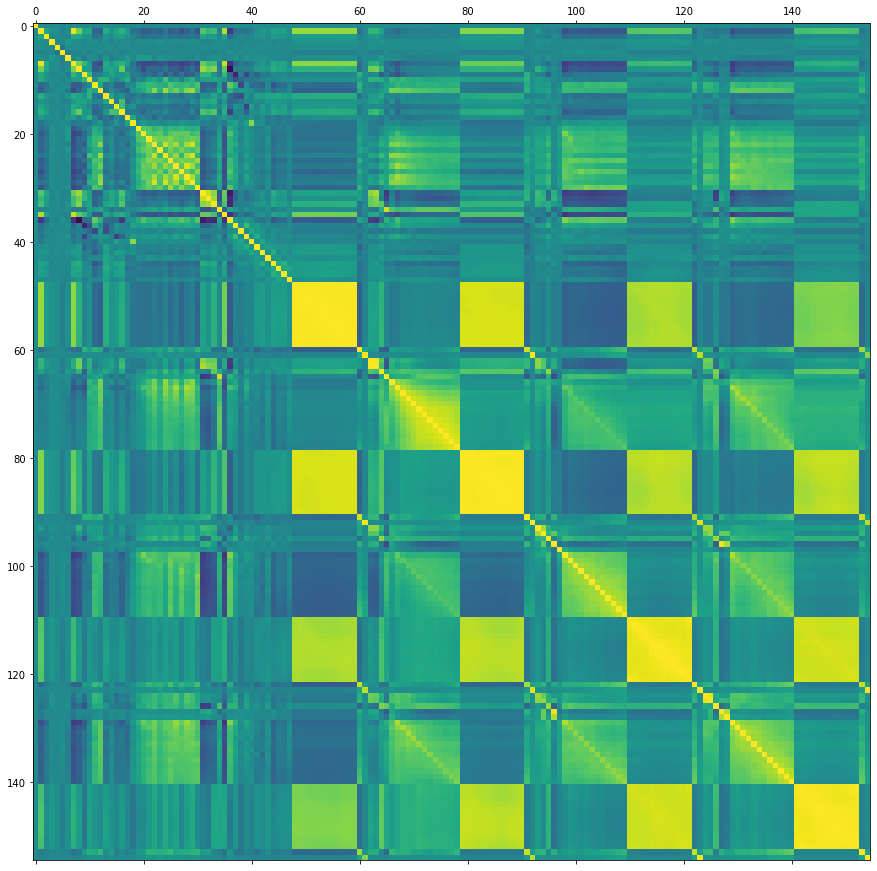

In [18]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.matshow(X_train.corr())
plt.show()


In [19]:
def correlation(df):
    corr = round(df.corr(),2)
    fig, ax = plt.subplots()
    im = ax.imshow(corr)

    ax.set_xticks(np.arange(len(corr.columns)))
    ax.set_yticks(np.arange(len(corr.index)))
    ax.set_xticklabels(corr.columns)
    ax.set_yticklabels(corr.index)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    for i in range(len(corr.columns)):
        for j in range(len(corr.index)):
            text = ax.text(j, i, corr.iloc[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Correlation matrix")
    fig.tight_layout()
    plt.rcParams['figure.figsize'] = [15, 15]
    plt.show()

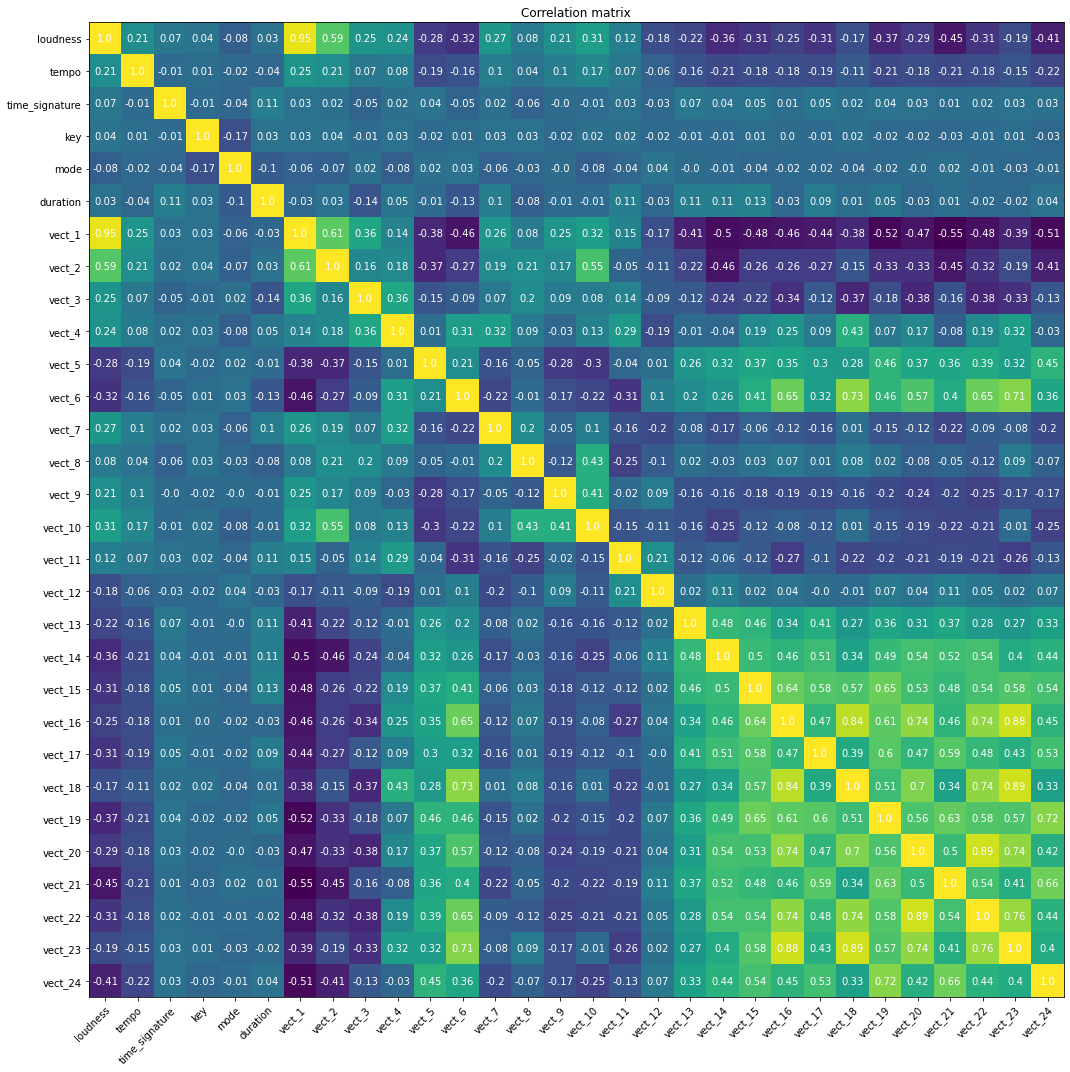

In [20]:
correlation(X_train.iloc[:,1:33])

#### Explore labels

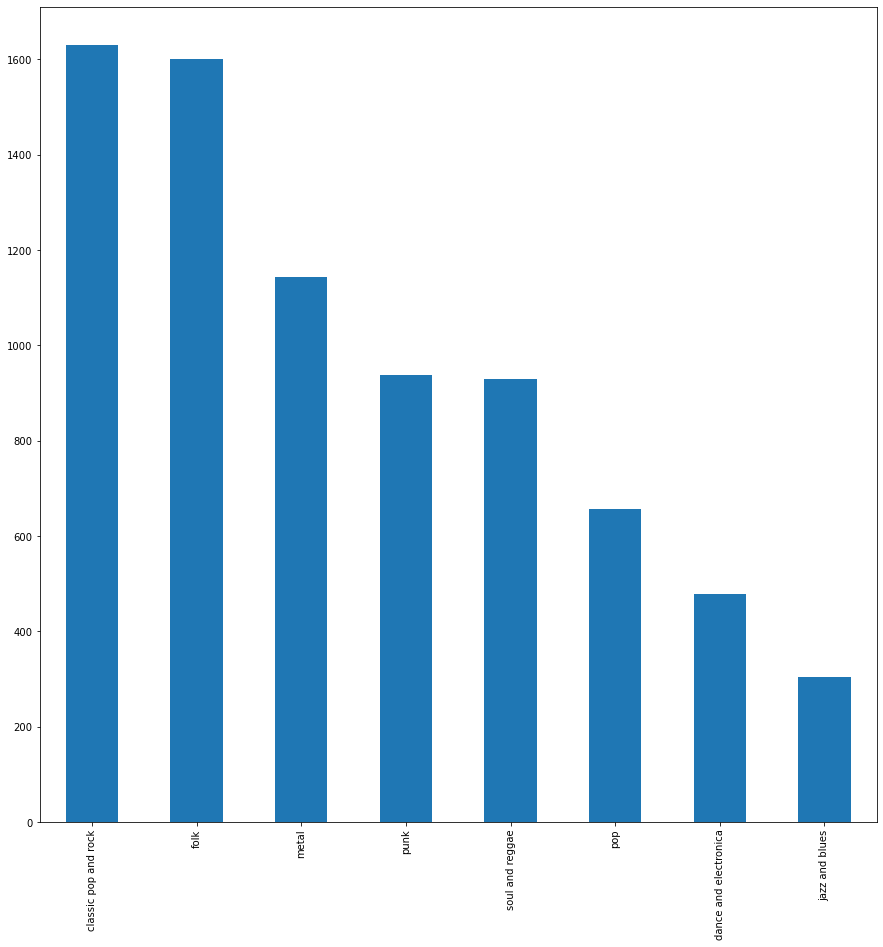

In [21]:
#Cheak label distribution
y_train.genre.value_counts().plot(kind='bar');

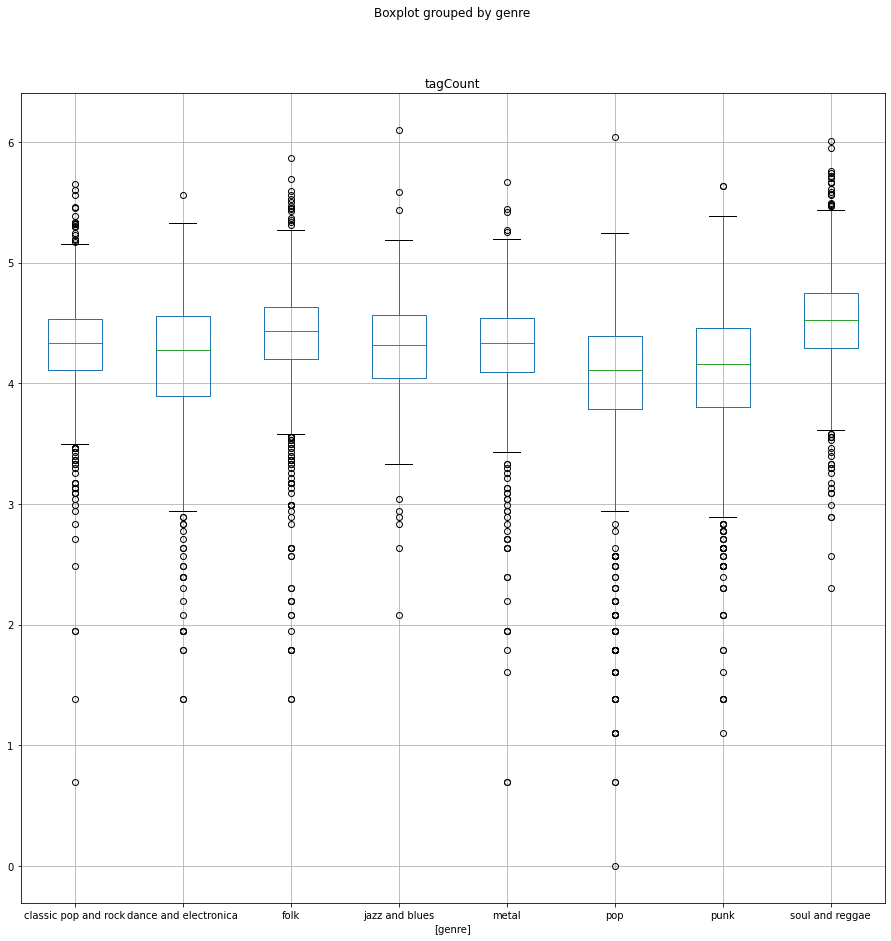

In [22]:
# tagCount distribution ove genre
tt = X_train.merge(y_train, on='trackID')
tt['tagCount'] = np.log([len(word) for word in tt.tags.str.split(",")])
tt[['tagCount','genre']].boxplot(by='genre')


## Data wrangle

### Handle text

Tags resumes most frecuent words, but many of those frequent words are meaningless as they are so common that they appear in most songs as their are pronouns, prepositions, conjunctions and interjections.

Two strategies can be used. First we can try to ignore them using a list of "stopwords" as reference. Such list is very generic and contains most common prepositions, pronouns and conjunctions. However, it does not deal with domain specific frequent words. Therefore,  a second strategy is used to handle such cases. Term Frequency Invserse DOcument Frequency (TF-IDF) is used. TF-IDF count the frecuency of words for each instance (Term frequency) but also count in how many instances a word (the document frecuency DF) and uses its inverted value to weight the word frecuency. Then if a word is shown in many instances its predictive value is less important. Nevertheless, the lyrics have been al ready pre-process, therefore, are summaried in unique keywords for instance.

One form to test if this transformation of data is still useful is to measure its mutual information with the class label. It is possible to test this against a simpler version of these vector that only consider the word frecuency.


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import mutual_info_classif

TFIDFvector = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range = (1,1), min_df=10)
Countvector = CountVectorizer(stop_words='english', ngram_range = (1,1), min_df=10)

tfidf = TFIDFvector.fit_transform(X_train.tags)
count = Countvector.fit_transform(X_train.tags)

t = mutual_info_classif(tfidf, y_train.genre, discrete_features=True)
c = mutual_info_classif( count, y_train.genre, discrete_features=True)
print("Total mutual information: \n\nTFIDF: {0:30}\nSimple count: {1:30}".format(t.mean(),c.mean()))

Total mutual information: 

TFIDF:            0.02424593654147177
Simple count:            0.00299670841502977


#### Evaluate additional feature

In [24]:
mutual_info_classif(tt[['tagCount']], y_train.genre, discrete_features=True)

array([0.16498633])

### Handle categorical

For categorical feature as the key a simple one-hot encoding would be enough.

### Handle Continues

For continuous values there are several transformation that can help the data to be able for algorithm consumption. First, normalization or standarization will help to set variables to share similar scale which can introduce some artificial weigth for certain variables to some metrics such as similarity or distance vector. Then, it is possible to turn set bins for certain variables.

In [25]:
#Cheack for normality
from scipy.stats import shapiro, normaltest, chisquare, jarque_bera, kstest, boxcox

for i in X_train.iloc[:,3:].columns:
    #print(i)
    stat, p = normaltest(X_train[i])
    if p > 0.05:
        print(i)
  #no normality found  

In [42]:
#Train with TFIDF

def preprocess(X_train, X_test, tfidf = True):
    
    from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
    from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer,scale
    #Handle categorical features
    X = pd.get_dummies(X_train, columns = ["key"], drop_first= True)
    Xt = pd.get_dummies(X_test, columns = ["key"], drop_first= True)
    #reorder
    X = pd.concat([X.iloc[:,:8],X.iloc[:,-11:] , X.iloc[:,8:-11]], axis=1)
    Xt = pd.concat([Xt.iloc[:,:8],Xt.iloc[:,-11:] , Xt.iloc[:,8:-11]], axis=1)
    #add feature
    X['tagCount'] = [len(i) for i in X.tags.str.split(',')]
    Xt['tagCount'] = [len(i) for i in Xt.tags.str.split(',')]
    
    #handle text features
    
    if tfidf:
        vect = TfidfVectorizer(stop_words='english', ngram_range = (1,1), min_df=10)
        vectT = TfidfVectorizer(stop_words='english', ngram_range = (1,1), min_df=10)
    else:
        vect = CountVectorizer(stop_words='english', ngram_range = (1,1), min_df=10)
        vectT = CountVectorizer(stop_words='english', ngram_range = (1,1), min_df=10)
    
    #calculate scores
    matrix = vect.fit_transform(X.tags)
    df1 = pd.DataFrame(matrix.toarray(), columns=vect.get_feature_names())
        #separete matrix for title
    matrixT = vectT.fit_transform(X.title)
    titleNames = [i + "T" for i in vectT.get_feature_names()]
    df2 = pd.DataFrame(matrixT.toarray(), columns=titleNames)
        
    #transform testing
    matrixt = vect.transform(Xt.tags)
    df3 = pd.DataFrame(matrixt.toarray(), columns=vect.get_feature_names())
    matrixtT = vectT.transform(Xt.title)
    df4 = pd.DataFrame(matrixtT.toarray(), columns=titleNames)
        
    X2 = pd.concat([X,df1,df2], axis = 1)
    Xt2 = pd.concat([Xt, df3, df4], axis = 1)
    
    #handle continuos
    
    scaler = MinMaxScaler()
        
    #3:156
    normal = scaler.fit_transform(X2.iloc[:,3:])
    X4 = X2.copy()
    X4.iloc[:,3:] = normal
    
    normalT = scaler.transform(Xt2.iloc[:,3:])
    Xtest = Xt2.copy()
    Xtest.iloc[:,3:] = normalT

    
    return X4, Xtest


Xtrain, Xtest = preprocess(X_train, X_test)

Standarization was tried but no feature seems to follow a normal distribution after tested.

### Feature selection

Entropy, information gain, mutual information or dimensionality reduction. Mutual information is implemented in sklearn

In [81]:
from sklearn.feature_selection import mutual_info_classif

def mutualInfoScores(df, y):
    res = zip(df.columns,
                   mutual_info_classif(df, y, discrete_features=True)
                   )
    sorted_scores = sorted(res, key= lambda k: k[1], reverse=True)
    return sorted_scores


#Get scores for each feature
#ignore trackID, title and tags fetures
scores = mutualInfoScores(Xtrain.iloc[:,3:], y_train.genre)
  

#### Oversampling minority classes

In [82]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
ros = SMOTE()
X_resampled, y_resampled = ros.fit_resample(Xtrain.iloc[:,3:], y_train.genre)

#### Discretizer continuos

In [83]:
features2bin = [3,4,5,7] +[i for i in range(19,168)]
from sklearn.preprocessing import KBinsDiscretizer
kbins = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='uniform')
XDis50 = kbins.fit_transform(Xtrain.iloc[:,features2bin])
XDis50Test =kbins.transform(Xtest.iloc[:,features2bin])

kbins = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
XDis20 = kbins.fit_transform(Xtrain.iloc[:,features2bin])
XDis20Test = kbins.transform(Xtest.iloc[:,features2bin])

#### Create datasets

In [84]:
full = Xtrain.iloc[:,3:]
fullTest = Xtest.iloc[:,3:]
X1000 = Xtrain[[i for i,e in scores[:1000]]]
Xtest1000 = Xtest[[i for i,e in scores[:1000]]]

X2000 = Xtrain[[i for i,e in scores[:2000]]]
Xtest2000 = Xtest[[i for i,e in scores[:2000]]]

X3000 = Xtrain[[i for i,e in scores[:3000]]]
Xtest3000 = Xtest[[i for i,e in scores[:3000]]]

X2000resampled = X_resampled[[i for i,e in scores[:2000]]]

onlyNLP = Xtrain.iloc[:,168:]
onlyNLPtest = Xtest.iloc[:,168:]
onlyVect = Xtrain.iloc[:,19:167]
onlyVectTest = Xtest.iloc[:,19:167]

bN = [i for i in range(3,19)] +[i for i in range(167,4109)]
baseNLP = Xtrain.iloc[:,bN]
baseNLPtest = Xtest.iloc[:,bN]
baseVect = Xtrain.iloc[:,3:168]
baseVectTest= Xtest.iloc[:,3:168]


### PCA

In [106]:
from sklearn.decomposition import PCA, TruncatedSVD

pca = PCA(n_components=50)
pca.fit(onlyVect)

Xpca =pca.transform(onlyVect)
Xpcatest =pca.transform(onlyVectTest)

## Algorithm selection

- Naive Bayes
- KNN
- Log Regression
- Support Vector Machines
- Decision Trees
- Random Forest

#### Get baseline

As baseline for a multiclass problem a one-R base may work.

### Model testing

Write multiple testing function

In [87]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

def trainModels(X, y, X_test, y_test, seed = 0):
    clfNames= ['baseline 1-R','NaiveBayes', 'KNN', 'Logistic', "SVM", 'DecTree', 'RandomForest']
    classifiers = [DecisionTreeClassifier(max_depth=1, random_state=seed),
                  GaussianNB(), 
                  KNeighborsClassifier(n_neighbors =1 , n_jobs= 4), 
                  LogisticRegression(n_jobs= 4, random_state=seed), 
                  SVC(kernel= "poly", random_state=seed), 
                  DecisionTreeClassifier(max_depth=500, random_state=seed), 
                  RandomForestClassifier(n_jobs=4,random_state=seed)]
    scores={}
    for name, clf in zip(clfNames, classifiers):
        clf.fit(X, y)
        prediction = clf.predict(X_test)
        scores[name] = {'Accuracy':clf.score(X_test, y_test),'f1-score':
            metrics.f1_score(y_test, prediction, average= 'weighted')}
    return scores


#### Evaluation

In [95]:
def evaluate(datasets):
    d = {}
    for name, x, test in datasets:
        if not 'Oversample' in name:
            d[name] = trainModels(x,y_train.genre,test, y_test.genre)
        else:
            d[name] = trainModels(x,y_resampled,test, y_test.genre)
    return d
        

In [96]:
datasets = [
        ('Full', full, fullTest),
        ('X1000',X1000,Xtest1000),
        ('X2000',X2000,Xtest2000),
        ('X3000',X3000,Xtest3000),
        ('Oversample',X_resampled,fullTest),
        ('Oversample2000', X2000resampled, Xtest2000), 
        ("OnlyNLP",onlyNLP,onlyNLPtest),
        ("OnlyVec",onlyVect,onlyVectTest),
        ('Base+NLP',baseNLP,baseNLPtest),
        ('Base+Vec',baseVect,baseVectTest),
        ('bin20',XDis20,XDis20Test),
        ('bin50',XDis50,XDis50Test),
        ("pca", Xpca, Xpcatest)
    ]

d = evaluate(datasets[:4]);

In [97]:
d2 = evaluate(datasets[4:8]);

In [98]:
d3 = evaluate(datasets[8:]);

In [99]:
#merge dictionaries
dt = {**d, **d2, **d3}

In [102]:
reform = {(level1_key, level2_key, level3_key): values
           for level1_key, level2_dict in dt.items()
           for level2_key, level3_dict in level2_dict.items()
           for level3_key, values      in level3_dict.items()}
q= pd.DataFrame(reform, index=[1])
table = q.T.unstack(level=0).T

In [104]:
table.to_excel("accuF.xlsx")

In [103]:
q.T.unstack(level=0)

1                                          \
                       Base+NLP  Base+Vec      Full   OnlyNLP   OnlyVec   
DecTree      Accuracy  0.388889  0.333333  0.411111  0.375556  0.333333   
             f1-score  0.389068  0.341317  0.418519  0.371682  0.338414   
KNN          Accuracy  0.191111  0.326667  0.193333  0.162222  0.366667   
             f1-score  0.164863  0.322538  0.189047  0.121233  0.372360   
Logistic     Accuracy  0.571111  0.488889  0.620000  0.562222  0.451111   
             f1-score  0.553228  0.477680  0.608792  0.537570  0.422035   
NaiveBayes   Accuracy  0.417778  0.415556  0.417778  0.415556  0.402222   
             f1-score  0.405798  0.421235  0.405936  0.402103  0.408250   
RandomForest Accuracy  0.608889  0.477778  0.604444  0.584444  0.440000   
             f1-score  0.563605  0.454169  0.582479  0.550466  0.427432   
SVM          Accuracy  0.535556  0.511111  0.642222  0.348889  0.500000   
             f1-score  0.516566  0.519828  0.616562  0.326445  0.505838   
baseline 1-R Accuracy  0.264444  0.255556  0.255556  0.275556  0.255556   
             f1-score  0.132226  0.131526  0.131526  0.169260  0.131526   

                                                                               \
                      Oversample Oversample2000     X1000     X2000     X3000   
DecTree      Accuracy   0.433333       0.428889  0.408889  0.422222  0.406667   
             f1-score   0.436380       0.433281  0.414901  0.427061  0.410455   
KNN          Accuracy   0.300000       0.326667  0.226667  0.242222  0.257778   
             f1-score   0.261979       0.275923  0.170396  0.179195  0.214921   
Logistic     Accuracy   0.617778       0.620000  0.633333  0.626667  0.628889   
             f1-score   0.612249       0.612584  0.622654  0.616146  0.615405   
NaiveBayes   Accuracy   0.433333       0.462222  0.464444  0.424444  0.406667   
             f1-score   0.423046       0.443987  0.433089  0.407463  0.390283   
RandomForest Accuracy   0.626667       0.626667  0.613333  0.617778  0.606667   
             f1-score   0.615465       0.621046  0.583475  0.589121  0.576689   
SVM          Accuracy   0.662222       0.662222  0.646667  0.651111  0.648889   
             f1-score   0.651235       0.654143  0.626682  0.625774  0.620330   
baseline 1-R Accuracy   0.248889       0.248889  0.255556  0.255556  0.255556   
             f1-score   0.132929       0.132929  0.131526  0.131526  0.131526   

                                                     
                          bin20     bin50       pca  
DecTree      Accuracy  0.324444  0.313333  0.293333  
             f1-score  0.329599  0.318927  0.293341  
KNN          Accuracy  0.353333  0.355556  0.342222  
             f1-score  0.362328  0.368861  0.349778  
Logistic     Accuracy  0.515556  0.522222  0.453333  
             f1-score  0.513279  0.515631  0.424861  
NaiveBayes   Accuracy  0.388889  0.422222  0.397778  
             f1-score  0.388956  0.429852  0.401016  
RandomForest Accuracy  0.453333  0.502222  0.408889  
             f1-score  0.451558  0.487784  0.386076  
SVM          Accuracy  0.517778  0.542222  0.422222  
             f1-score  0.521311  0.545205  0.386649  
baseline 1-R Accuracy  0.248889  0.248889  0.226667  
             f1-score  0.133187  0.133187  0.122854

### Error analysis

In [158]:
y_resampled

0                  metal
1                   folk
2                   folk
3         jazz and blues
4                   folk
              ...       
13027    soul and reggae
13028    soul and reggae
13029    soul and reggae
13030    soul and reggae
13031    soul and reggae
Name: genre, Length: 13032, dtype: object

In [161]:
dttest={}
dttrain={}
for i in range(1300,13032,1000):
    print(i)
    R = RandomForestClassifier(n_jobs=-1).fit(X2000resampled.iloc[:i,:], y_resampled[:i])
    dttrain[i]= R.score(X2000resampled, y_resampled)
    dttest[i]= R.score(Xtest2000, y_test.genre)  

1300
2300
3300
4300
5300
6300
7300
8300
9300
10300
11300
12300


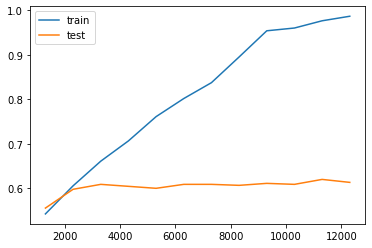

In [169]:
t = pd.DataFrame([dttrain, dttest]).T
t.columns = ['train', 'test']
t.plot()

## Hyperparameter tunning

#### Logistic regression

In [203]:
from sklearn.model_selection import GridSearchCV

parameters = {'penalty':('l1', 'l2', 'elasticnet','none'), 'class_weight':('balanced', None),
              'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'), 'multi_class': ('ovr','multinomial'), 'n_jobs': [4]}
svc = LogisticRegression()
clf = GridSearchCV(svc, parameters)
clf.fit(X2000, y_train.genre)

clf.best_score_
clf.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this 

{'class_weight': None,
 'multi_class': 'ovr',
 'n_jobs': 4,
 'penalty': 'l1',
 'solver': 'saga'}

In [204]:
clf.best_score_

0.6414444218241042

In [91]:
LR = LogisticRegression(multi_class='ovr', solver='saga', penalty= 'l1', n_jobs= 4).fit(X, y_train.genre)
LRT = LR.predict(X)

print(metrics.classification_report(y_train.genre, LRT))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

                       precision    recall  f1-score   support

 classic pop and rock       0.53      0.61      0.57      1629
dance and electronica       0.62      0.35      0.45       478
                 folk       0.60      0.69      0.64      1601
       jazz and blues       0.67      0.24      0.36       303
                metal       0.84      0.90      0.87      1143
                  pop       0.61      0.48      0.54       657
                 punk       0.72      0.70      0.71       937
      soul and reggae       0.61      0.60      0.60       930

             accuracy                           0.64      7678
            macro avg       0.65      0.57      0.59      7678
         weighted avg       0.64      0.64      0.63      7678



### Random forest tunning

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters={'max_depth': [10, 20, 50, 70, 100, None],
            'n_estimators': [100, 200, 400, 1000],
           'criterion': ('gini', 'entropy')}
RF = RandomForestClassifier(n_jobs=4)
clf = GridSearchCV(RF, parameters, n_jobs= -1)
clf.fit(X2000resampled, y_resampled)

clf.best_score_

In [132]:
clf.best_score_

0.8162312870979337

In [127]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 70, 'n_estimators': 1000}

In [129]:
brf = RandomForestClassifier(n_jobs=-1, max_depth=70, n_estimators= 1000)

brf.fit(X2000resampled, y_resampled)
rfp = brf.predict(Xtest2000)

print(metrics.classification_report(y_test.genre, rfp))

                       precision    recall  f1-score   support

 classic pop and rock       0.47      0.55      0.50        55
dance and electronica       0.76      0.29      0.42        45
                 folk       0.38      0.66      0.48        64
       jazz and blues       0.67      0.18      0.29        44
                metal       0.91      0.76      0.83        66
                  pop       0.95      0.99      0.97        74
                 punk       0.53      0.64      0.58        44
      soul and reggae       0.76      0.81      0.78        58

             accuracy                           0.65       450
            macro avg       0.68      0.61      0.61       450
         weighted avg       0.69      0.65      0.64       450



### SVM Tunning

In [136]:
from sklearn.model_selection import GridSearchCV

parameters={'kernel':('linear', 'poly', 'rbf', 'sigmoid', 'precomputed'),'C': [0.1,1,10] }
sv = SVC()
clf = GridSearchCV(sv, parameters, n_jobs= -1)
clf.fit(X2000resampled, y_resampled)
clf.best_score_

In [95]:
from sklearn.svm import SVC, LinearSVC
LR = SVC(kernel= 'poly').fit(X2000resampled, y_resampled)
LRT = LR.predict(Xtest2000)

print(metrics.classification_report(y_test.genre, LRT))

                       precision    recall  f1-score   support

 classic pop and rock       0.40      0.64      0.49        55
dance and electronica       0.48      0.27      0.34        45
                 folk       0.54      0.67      0.60        64
       jazz and blues       0.71      0.27      0.39        44
                metal       0.94      0.73      0.82        66
                  pop       0.93      0.96      0.95        74
                 punk       0.67      0.84      0.75        44
      soul and reggae       0.76      0.78      0.77        58

             accuracy                           0.67       450
            macro avg       0.68      0.64      0.64       450
         weighted avg       0.70      0.67      0.67       450

